# Semantic Segmentation with tf.data in TensorFlow 2 and ADE20K dataset

## 1. Introduction

In this notebook we are going to cover the usage of tensorflow 2 and tf.data on a popular semantic segmentation 2D images dataset: ADE20K.

The type of data we are going to manipulate consist in:
* an jpg image with 3 channels (RGB)
* a jpg mask with 1 channel (for each pixel we have 1 true class over 150 possible)  

You can also find all the information by reading the official tensorflow tutorials:

* https://www.tensorflow.org/tutorials/load_data/images
* https://www.tensorflow.org/tutorials/images/segmentation

This notebook assumes that your environment is Google Colab.

## 2. Preparing the Environment

In [8]:
from glob import glob
import shutil
import argparse
import zipfile
import hashlib
import requests
from tqdm import tqdm
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import tensorflow_addons as tfa

# For more information about autotune:
# https://www.tensorflow.org/guide/data_performance#prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Tensorflow ver. 2.6.0-dev20210402
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10120417761559950203
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4164354048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4190656069157176336
physical_device_desc: "device: 0, name: GeForce RTX 2060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
Default GPU Device: /device:GPU:0


In [9]:
# important for reproducibility
# this allows to generate the same random numbers
SEED = 42

We can implement a small tool to download ADE2k in colab environment directly.

In [10]:

root = "/home/aswath/Videos/myvideo/"
dataset_path = root + "mydata/images/"
training_data = "training/"
val_data = "validation/"


## 3. Creating our Dataloader

In [12]:
# Image size that we are going to use
IMG_SIZE = 128
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 150 classes + `not labeled`
N_CLASSES = 1

### 3.1. Creating a source dataset

In [13]:
TRAINSET_SIZE = len(glob(dataset_path + training_data + "*.jpg"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(dataset_path + val_data + "*.jpg"))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 10 images.
The Validation Dataset contains 5 images.


For each images of our dataset, we will apply some operations wrapped into a function. Then we will map the whole dataset with this function.   

So let's write this function:

In [23]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # For one Image path:
    # .../trainset/images/training/ADE_train_00000001.jpg
    # Its corresponding annotation path is:
    # .../trainset/annotations/training/ADE_train_00000001.png
    mask_path = tf.strings.regex_replace(img_path, "images", "annotations")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess up with our N_CLASS = 150
    # Since 255 means the 255th class
    # Which doesn't exist
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    # Note that we have to convert the new value (0)
    # With the same dtype than the tensor itself

    return {'image': image, 'segmentation_mask': mask}

In case you would like to load any other image format, you should modify the `parse_image` function. TensorFlow I/O provide additional tools that might help you. 
For example, in the case of loading TIFF images, you can use:

```python
import tensorflow as tf
import tensorflow.io as tfio
...
def parse_image(img_path: str) -> dict:
...
image = tf.io.read_file(img_path)
tfio.experimental.image.decode_tiff(image)
...
```

In this case, don't forget to modify the number of channels when implementing the model later.

In [31]:
train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.jpg", seed=SEED)
train_dataset = train_dataset.map(parse_image)

import cv2
for oneSet in train_dataset:
    #img = Image.fromarray(oneele['image'].numpy())
    cv2.imshow("Img", cv2.resize(oneSet['image'].numpy(),(300,300)))
    #image.show()
    np_img = np.squeeze(oneSet['segmentation_mask'].numpy(), axis=2)
    cv2.imshow("Mask",cv2.resize(np_img,(300,300)))
    cv2.waitKey(0)
    #imageseg = Image.fromarray(np_img)
    #imageseg.show()

val_dataset = tf.data.Dataset.list_files(dataset_path + val_data + "*.jpg", seed=SEED)
val_dataset =val_dataset.map(parse_image)

### 3.2. Applying some transformations to our dataset

In [16]:
# Here we are using the decorator @tf.function
# if you want to know more about it:
# https://www.tensorflow.org/api_docs/python/tf/function

@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [SIZE,SIZE,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [SIZE,SIZE,1].

    Returns
    -------
    tuple
        Normalized image and its annotation.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    """Apply some transformations to an input dictionary
    containing a train image and its annotation.

    Notes
    -----
    An annotation is a regular  channel image.
    If a transformation such as rotation is applied to the image,
    the same transformation has to be applied on the annotation also.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    """Normalize and resize a test image and its annotation.

    Notes
    -----
    Since this is for the test set, we don't need to apply
    any data augmentation technique.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

Manipulating datasets in tensorflow can be complicated. You can read the official documentation to understand how they are working: https://www.tensorflow.org/guide/data#training_workflows

In [18]:
BATCH_SIZE = 2

# for reference about the BUFFER_SIZE in shuffle:
# https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
BUFFER_SIZE = 5

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

# how shuffle works: https://stackoverflow.com/a/53517848

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


## 4. Visualizing the Dataset

It seems everything is fine. It can be very hard to build your model by having bugs in your dataset. This makes the development process very painful since the potential bugs from your model are adding up to the potential bugs in your dataloaders. Therefore, it is recommended to make sure that you have what you expect.  
For that, we are going to develop simple functions to vizualize the content of our dataloaders.

In [19]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

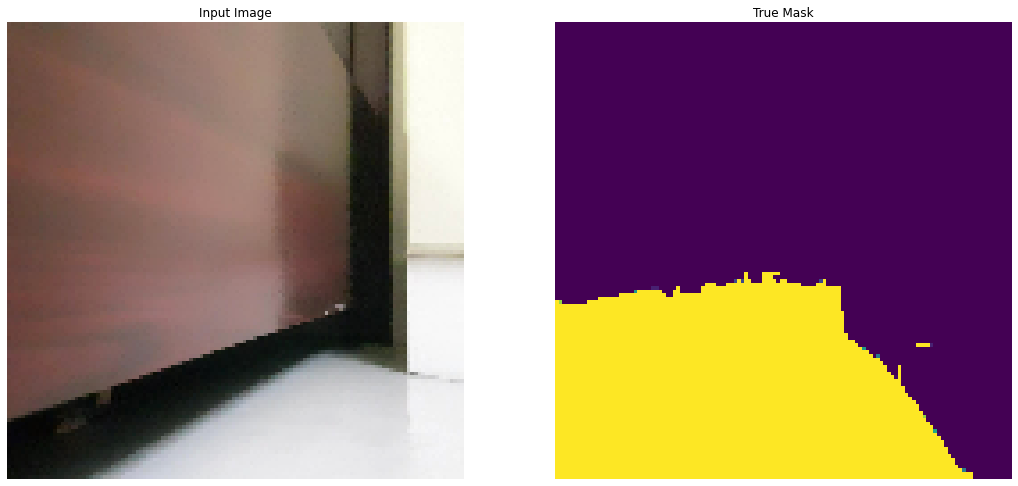

In [20]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

The dimensions are the ones we expect and it shows up properly. We can start the development of the model itself.

## 5. Developing the Model (UNet) Using Keras Functional API
For this example, we are going to implement a popular architecture: UNet. In a sense, it is not the best for a titorial since this model is very heavy. But I found the exercise interesting. Especially because we are going to use the functional API provided by keras.

This architecture was introduce in the paper **U-Net: Convolutional Networks for Biomedical Image Segmentation** that you can read there: https://arxiv.org/abs/1505.04597  

You can also read my notes on this paper there: https://yann-leguilly.gitlab.io/post/2019-12-11-unet-biomedical-images/   
Basically we are going to reproduce this:  

![figure 1](https://yann-leguilly.gitlab.io/img/unet_1/figure_1.png)

### 5.1. Implementation

In [18]:
# -- Keras Functional API -- #
# -- UNet Implementation -- #
# Everything here is from tensorflow.keras.layers
# I imported tensorflow.keras.layers * to make it easier to read
dropout_rate = 0.5
input_size = (IMG_SIZE, IMG_SIZE, N_CHANNELS)

# If you want to know more about why we are using `he_normal`: 
# https://stats.stackexchange.com/questions/319323/whats-the-difference-between-variance-scaling-initializer-and-xavier-initialize/319849#319849  
# Or the excelent fastai course: 
# https://github.com/fastai/course-v3/blob/master/nbs/dl2/02b_initializing.ipynb
initializer = 'he_normal'


# -- Encoder -- #
# Block encoder 1
inputs = Input(shape=input_size)
conv_enc_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(inputs)
conv_enc_1 = Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer=initializer)(conv_enc_1)

# Block encoder 2
max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(conv_enc_1)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_2)

# Block  encoder 3
max_pool_enc_3 = MaxPooling2D(pool_size=(2, 2))(conv_enc_2)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_3)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_3)

# Block  encoder 4
max_pool_enc_4 = MaxPooling2D(pool_size=(2, 2))(conv_enc_3)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_4)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_4)
# -- Encoder -- #

# ----------- #
maxpool = MaxPooling2D(pool_size=(2, 2))(conv_enc_4)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(maxpool)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv)
# ----------- #

# -- Dencoder -- #
# Block decoder 1
up_dec_1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv))
merge_dec_1 = concatenate([conv_enc_4, up_dec_1], axis = 3)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_1)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_1)

# Block decoder 2
up_dec_2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_1))
merge_dec_2 = concatenate([conv_enc_3, up_dec_2], axis = 3)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_2)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_2)

# Block decoder 3
up_dec_3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_2))
merge_dec_3 = concatenate([conv_enc_2, up_dec_3], axis = 3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_3)

# Block decoder 4
up_dec_4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_3))
merge_dec_4 = concatenate([conv_enc_1, up_dec_4], axis = 3)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_4)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
conv_dec_4 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
# -- Dencoder -- #

output = Conv2D(N_CLASSES, 1, activation = 'softmax')(conv_dec_4)

Now we can load and compile the model to make sure that there is no bugs.

In [19]:
model = tf.keras.Model(inputs = inputs, outputs = output)

In [20]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### 5.2. Sanity Check

We can visualize a sample prediction to be sure that we see what we expect.

In [21]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predicitons
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_SIZE, IMG_SIZE, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] mask with top 1 predictions
        for each pixels.
    """
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask
    
def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])

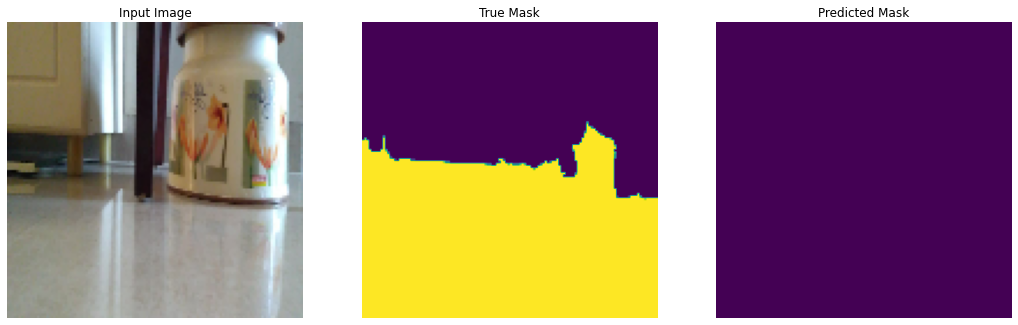

In [22]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

show_predictions()

The far right image is a prediction with random weights. We are ready to start the training!

## 6. Training our Model

### 6.1. Simpler training loop

Let's run a simple training loop with only 1 epoch first. 

In [23]:
EPOCHS = 1

STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.models import *

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [24]:
# sometimes it can be very interesting to run some batches on cpu
# because the tracing is way better than on GPU
# you will have more obvious error message
# but in our case, it takes A LOT of time

# On CPU
# with tf.device("/cpu:0"):
#     model_history = model.fit(dataset['train'], epochs=EPOCHS,
#                               steps_per_epoch=STEPS_PER_EPOCH,
#                               validation_steps=VALIDATION_STEPS,
#                               validation_data=dataset['val'])

# On GPU
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'])

12/12 [==============================] - 8s 171ms/step - loss: 0.6483 - accuracy: 0.6864 - val_loss: 0.4418 - val_accuracy: 0.9801


Everything looks great! We can start our 'real' training.

### 6.2. More Advanced Training Loop

Keras implements what we call 'callbacks'. We can use them to run custom functions at any step of the training. Here we are going to show the output of the model compared to the original image and the ground truth after each epochs.
We are also going to collect some useful metrics to make sure our training is happening well by using tensorboard.

In [25]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [26]:
EPOCHS = 4

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [
    # to show samples after each epoch
    DisplayCallback(),
    # to collect some useful metrics and visualize them in tensorboard
    tensorboard_callback,
    # if no accuracy improvements we can stop the training directly
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    # to save checkpoints
    tf.keras.callbacks.ModelCheckpoint('best_model_unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

model = tf.keras.Model(inputs = inputs, outputs = output)

# # here I'm using a new optimizer: https://arxiv.org/abs/1908.03265
optimizer=tfa.optimizers.RectifiedAdam(lr=1e-3)

loss = tf.keras.losses.SparseCategoricalCrossentropy()

/home/aswath/anaconda3/envs/rosconda/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [27]:
model.compile(optimizer=optimizer, loss = loss,
                  metrics=['accuracy'])

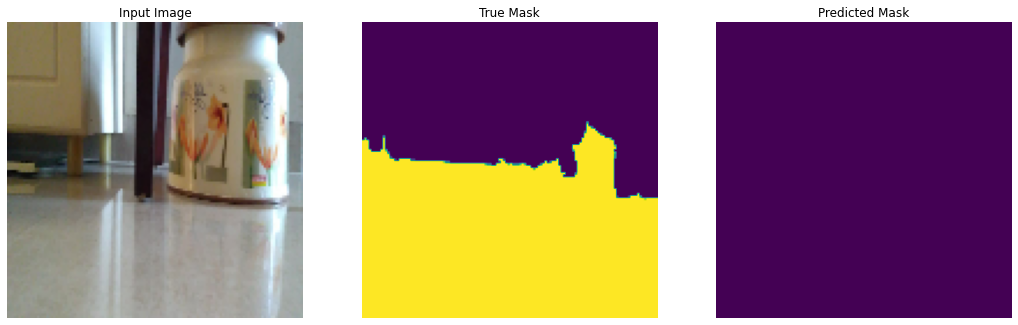


Sample Prediction after epoch 1


Epoch 00001: val_loss improved from inf to 0.47981, saving model to best_model_unet.h5
Epoch 2/4
 3/12 [======>.......................] - ETA: 1s - loss: 0.5141 - accuracy: 0.6198

KeyboardInterrupt: 

In [28]:
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    validation_data=dataset['val'],
                    callbacks=callbacks)
model.save('saved_model.h5')


In [6]:

import matplotlib.pyplot as plt

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

NameError: name 'model_history' is not defined

In [3]:
def dispimg(mmm):
    plt.figure(figsize=(5, 5))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mmm))
    plt.axis('off')
    plt.show()

In [6]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from IPython.display import clear_output
from tensorflow_addons.optimizers import RectifiedAdam

#tf.keras.optimizers.RectifiedAdam = RectifiedAdam


from tensorflow import keras
import tensorflow as tf
model = keras.models.load_model('saved_model.h5')
import time 

capture = cv2.VideoCapture("/home/aswath/Videos/myvideo/groundvideo.mp4")

if capture.isOpened():
        print("Device Opened\n")
else:
        print("Failed to open Device\n")
    
ret, image = capture.read()
print(image.shape)
i=0
while(capture.isOpened()):
    ret, image = capture.read()
    if ret==False:
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imres = cv2.resize(image, (128, 128)) 
    imsize = imres.astype("float") / 255.0
    imsize = img_to_array(imsize)
    imsize = np.expand_dims(imsize, axis=0)
    print(imsize.shape)
    #t1= time.time()
    pred_mask = model.predict(imsize)
    #print("Time take(seconds): ", time.time()-t1)
    #break
    clear_output(wait=True)
    i=i+1
    print(i)
    ground_mask = pred_mask[0,:,:,1]
    ground_mask = ground_mask/ground_mask.max()
    ground_mask *= 255
    ground_mask = ground_mask.astype(np.uint8)
    ground_overlay = imres

    #dispimg(create_mask(pred_mask)[0]+imres)
    #dispimg(ground_overlay)  
    '''
    plt.close()
    plt.figure(figsize=(18, 18))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(create_mask(m)))
    plt.axis('off')
    plt.show()
    '''
    #m=create_mask(pred_mask)[0]
    #print(m.shape)
    #imres=np.uint8(imres)
    
    ground_overlay = cv2.cvtColor(ground_overlay, cv2.COLOR_RGB2BGR)
    ground_overlay[:,:,0] += ground_mask
    ground_overlay = cv2.resize(ground_overlay, (300, 300)) 

    cv2.imshow("image",ground_overlay)
    if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
out.release()
cv2.destroyAllWindows()
  
    

Device Opened

(720, 1280, 3)
(1, 128, 128, 3)
Time take(seconds):  0.2204115390777588


NameError: name 'cap' is not defined

In [3]:

from tensorflow import keras
import tensorflow as tf
from tensorflow_addons.optimizers import RectifiedAdam
net = keras.models.load_model('saved_model.h5')


In [3]:
#import keras2onnx
net.save('savenet')
# $ python -m tf2onnx.convert --opset 12 --saved-model "./savenet" --output "model.onnx"

INFO:tensorflow:Assets written to: savenet/assets


In [8]:
import onnx

# Load the ONNX model
model = onnx.load("model.onnx")

# Check that the IR is well formed
onnx.checker.check_model(model)


Using the SavedModel format

In [1]:
tf.saved_model.save(net, "./")


NameError: name 'tf' is not defined

In [11]:
import tensorflow as tf

writer = tf.summary.create_file_writer("logs_dir")

with writer.as_default():
  for step in range(100):
    # other model code would go here
    tf.summary.scalar("my_metric", 0.5, step=step)
    writer.flush()

/bin/bash: /home/aswath/anaconda3/envs/rosconda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/aswath/Capstone_Project/catkin_ws/src/nxtbot/scripts


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np
#path of the directory where you want to save your model
frozen_out_path = './'
# name of the .pb file
frozen_graph_filename = "frozen_graph"
model = net
# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 60)
print("Frozen model layers: ")
for layer in layers:
    print(layer)
print("-" * 60)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)
# Save frozen graph to disk
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pb",
                  as_text=False)
# Save its text representation
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pbtxt",
                  as_text=True)

------------------------------------------------------------
Frozen model layers: 
x
model_1/conv2d/Conv2D/ReadVariableOp/resource
model_1/conv2d/Conv2D/ReadVariableOp
model_1/conv2d/Conv2D
model_1/conv2d/BiasAdd/ReadVariableOp/resource
model_1/conv2d/BiasAdd/ReadVariableOp
model_1/conv2d/BiasAdd
model_1/conv2d/Relu
model_1/conv2d_1/Conv2D/ReadVariableOp/resource
model_1/conv2d_1/Conv2D/ReadVariableOp
model_1/conv2d_1/Conv2D
model_1/conv2d_1/BiasAdd/ReadVariableOp/resource
model_1/conv2d_1/BiasAdd/ReadVariableOp
model_1/conv2d_1/BiasAdd
model_1/conv2d_1/Relu
model_1/max_pooling2d/MaxPool
model_1/conv2d_2/Conv2D/ReadVariableOp/resource
model_1/conv2d_2/Conv2D/ReadVariableOp
model_1/conv2d_2/Conv2D
model_1/conv2d_2/BiasAdd/ReadVariableOp/resource
model_1/conv2d_2/BiasAdd/ReadVariableOp
model_1/conv2d_2/BiasAdd
model_1/conv2d_2/Relu
model_1/conv2d_3/Conv2D/ReadVariableOp/resource
model_1/conv2d_3/Conv2D/ReadVariableOp
model_1/conv2d_3/Conv2D
model_1/conv2d_3/BiasAdd/ReadVariableOp/resourc

'./frozen_graph.pbtxt'